In [1]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt

from CCfit import fit
from CCfit import gauss

In [2]:
%matplotlib inline

In [3]:
def get_index(filename):
    return int(os.path.basename(filename).split("_")[-2])

def get_double_index(filename):
    return (int(os.path.basename(filename).split("_")[-3]) * 100 + 
            int(os.path.basename(filename).split("_")[-2]))

def load_ccd_file(filename_signal):
    filename_power = filename_signal.replace("_signal", "_power")

    wls, counts = np.loadtxt(filename_signal, delimiter="\t", skiprows=28).T
    time, power = np.loadtxt(filename_power , delimiter=","              ).T
    
    return time.mean(), power.mean(), wls, counts

def fit_integral(x, y):
    fit_range = 700, 810
    fit_range = 650, 880
    f = fit(gauss, x, y - 3050, (1e4, 770, 30), fit_range=fit_range)
    return f.values[0]

In [4]:
folder = "/home/gonzalo/data/CC-old/CaF_long_bleach_recovery_4/"

files = sorted(glob.glob(os.path.join(folder, "*signal*")), key=get_index)

times, powers, wls, counts = map(np.array, zip(*map(load_ccd_file, files)))
times = times - times.min()
times = times / 3600
integrals = np.array(list(map(fit_integral, wls, counts)))

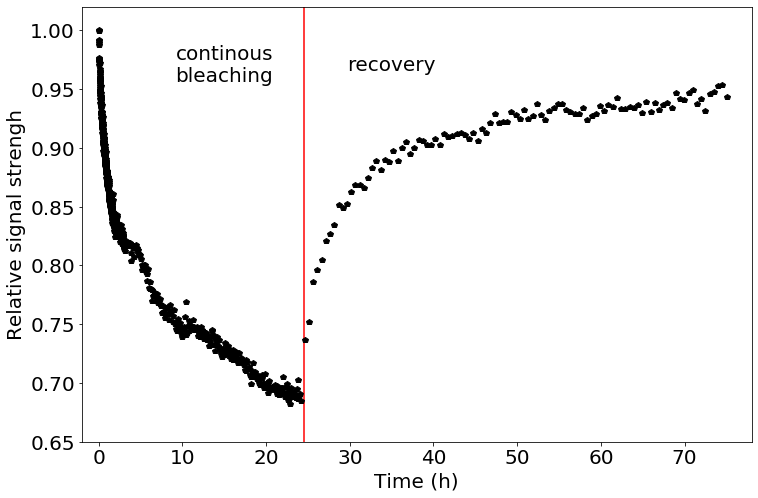

In [5]:
sel = np.ones(len(times), dtype=bool)
sel[275] = False
sel[550] = False
sel[695] = False

plt.figure(figsize=(12, 8))

xlim = -2, 78
ylim = 0.65, 1.02

plt.plot(times[sel], integrals[sel]/integrals.max(), "pk")
plt.xlabel("Time (h)", fontsize=20)
plt.ylabel("Relative signal strengh", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.vlines(24.5, *ylim, "r")
plt.xlim(xlim)
plt.ylim(ylim)
plt.text(15, 0.97, "continous\nbleaching", ha="center", va="center", fontsize=20)
plt.text(35, 0.97, "recovery", ha="center", va="center", fontsize=20)

plt.savefig("/home/gonzalo/Escritorio/bleach_recovery_sequential.pdf")
plt.savefig("/home/gonzalo/Escritorio/bleach_recovery_sequential.png")

In [6]:
folder = "/home/gonzalo/data/CC-old/caf_conversion/600_400/"

times     = {}
powers    = {}
wls       = {}
counts    = {}
integrals = {}

tmin = np.inf
for wl in (600, 400):
    files = sorted(glob.glob(os.path.join(folder, f"*_{wl}_*signal*")), key=get_double_index)

    ts, ps, ws, cs = map(np.array, zip(*map(load_ccd_file, files)))
    tmin = min(ts.min(), tmin)
    ints = np.array(list(map(fit_integral, ws, cs)))
    
    times    [wl] = ts
    powers   [wl] = ps
    wls      [wl] = ws
    counts   [wl] = cs
    integrals[wl] = ints
    
for wl in (600, 400):
    times[wl] = (times[wl] - tmin) / 3600

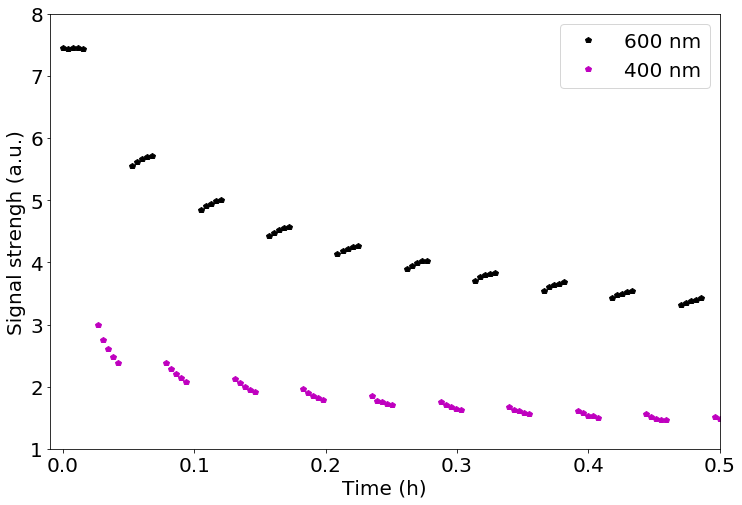

In [7]:
plt.figure(figsize=(12, 8))

xlim = -.01, 0.5
ylim = 1, 8

plt.plot(times[600], integrals[600]/powers[600]/1e10, "pk", label="600 nm")
plt.plot(times[400], integrals[400]/powers[400]/1e10, "pm", label="400 nm")
plt.legend(fontsize=20)
plt.xlabel("Time (h)", fontsize=20)
plt.ylabel("Signal strengh (a.u.)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(xlim)
plt.ylim(ylim)

plt.savefig("/home/gonzalo/Escritorio/bleach_recovery_alternate.pdf")
plt.savefig("/home/gonzalo/Escritorio/bleach_recovery_alternate.png")